Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then run the cells accordingly.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "江詠筑"
COLLABORATORS = "=="

---

# AI Agent and Problem Solving by Search

Implementation of search algorithms and search problems for AIMA.
Adpated from https://github.com/aimacode/aima-python/blob/master/search4e.ipynb
Used in Introduction to AI (Robotics) course at NYCU, 2021.

We start by defining the abstract class for a `Problem`; problem domains will subclass this, and then you can create individual problems with specific initial states and goals. We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors, and `path_actions`, `path_states` and `path` to recover aspects of the path from the node.  Finally, a `PriorityQueue`, which allows you to keep a collection of items, and continually remove from it the item with minimum `f(item)` score.\


## Import python package & module

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations
import unittest

## Problem abstract class definition

In [ ]:
class Problem(object):
    def __init__(self, initial=None, goal=None, **other_keywords):
        """Specify the initial and goal states.
        Subclasses can use other keywords if they want."""
        self.__dict__.update(initial=initial, goal=goal, **other_keywords) 

    def actions(self, state):           raise NotImplementedError
    def result(self, state, action):    raise NotImplementedError
    def is_goal(self, state):           return state == self.goal
    def step_cost(self, s, action, s1): return 1
    def h(self, node):                  return 0

# The Route-Finding Problem

Like all state-space search problems, in a route-finding problem you will be given:
- A start state (for example, `'A'` for the city Arad).
- A goal state (for example, `'B'` for the city Bucharest).
- Actions that can change state (for example, driving from `'A'` to `'S'`).

You will be asked to find:
- A path from the start state, through intermediate states, to the goal state.

We'll use this map:

![picture](https://drive.google.com/uc?id=1G11cF7NEqVp24SNfHKyKal7TvEsTJgGQ)

A state-space search problem can be represented by a *graph*, where the vertices of the graph are the states of the problem (in this case, cities) and the edges of the graph are the actions (in this case, driving along a road).

We'll represent a city by its single initial letter. 
We'll represent the graph of connections as a `dict` that maps each city to a list of the neighboring cities (connected by a road). For now we don't explicitly represent the actions, nor the distances
between cities.

## Map Definition

In [ ]:
def sldistance(A, B):
    "Straight-line distance between two 2D points."
    return abs(complex(*A) - complex(*B))

def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

def multimap(pairs):
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    `links` can be either [(v1, v2)...] pairs, or {(v1, v2): distance...}.
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1).
    `locations` is optional and can be {v1: (x, y)} 2D locations of vertexes."""
    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Make `links` into a dict
            links = defaultdict(lambda: 1, links)
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.locations = locations or defaultdict(lambda: (0, 0))
        self.neighbors = multimap(links)

romania = Map(
    {('O', 'Z'): 71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'): 70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'): 80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'): 90, ('B', 'U'): 85, ('H', 'U'): 98,  ('E', 'H'): 86, ('U', 'V'): 142, 
     ('I', 'V'): 92, ('I', 'N'): 87, ('P', 'R'): 97},
    dict(
    A=(91, 492), B=(400, 327), C=(253, 288), D=(165, 299), E=(562, 293), F=(305, 449),
    G=(375, 270), H=(534, 350), I=(473, 506), L=(165, 379), M=(168, 339), N=(406, 537),
    O=(131, 571), P=(320, 368), R=(233, 410), S=(207, 457), T=(94, 410), U=(456, 350),
    V=(509, 444), Z=(108, 531)))

In [ ]:
print(romania.neighbors['A'])
print(romania.distances['A', 'Z'])
print('A to B:', sldistance(romania.locations['A'], romania.locations['B']))

['Z', 'S', 'T']
75
A to B: 350.2941620980858


In [ ]:
class RouteProblem(Problem):
    """A problem to find a route between places on a map.
    Use RouteProblem('S', 'G', map=Map(...)})"""
    
    def actions(self, state): 
        """The places neighboring `state`. (Action names are same as place names.)"""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def step_cost(self, s, action, s1):
        """The actual distance between s and s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return sldistance(locs[node.state], locs[self.goal])
    

In [ ]:
class TestRouteProblem(unittest.TestCase):
    """Example of how to use unittest in Jupyter."""
    
    def test_actions(self):
        problem_r1 = RouteProblem('A', 'B', map=romania)
        self.assertEqual(problem_r1.actions('A'), ['Z', 'S', 'T'])
        self.assertEqual(len(problem_r1.actions('A')), 3)

    def test_result(self):
        problem_r1 = RouteProblem('A', 'B', map=romania)
        self.assertEqual(problem_r1.result('A', 'S'), 'S')        

    def test_step_cost(self):
        problem_r1 = RouteProblem('A', 'B', map=romania)
        self.assertEqual(problem_r1.step_cost('A', 'S', 'S'), 140)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


---
## Part A (1 points)

Write a test function for map definition.

In [ ]:
def test_map(romania):
    '''
    out_1: Show the neighbors of the place A
    out_2: Show distance between two adjacent place A to Z
    out_3: Show the location infomation of the place A
    '''
    # YOUR CODE HERE
    out_1 = romania.neighbors['A']
    out_2 = romania.distances['A','Z']
    out_3 = romania.locations['A']
    return out_1 , out_2 , out_3

In [ ]:
out_1, out_2, out_3 = test_map(romania)

# Show the neighbors of the place A
assert out_1 == ['Z', 'S', 'T']
# Show distance between two adjacent place A to Z
assert out_2 == 75
# Show the location infomation of the place A
assert out_3 == (91, 492)

# Problem Solving by Search

## Node definition

In [ ]:
class Node:
    '''A Node in a search tree.'''
    def __init__(self, state, parent=None, action=None, path_cost=0):
        # __dict__ store this object's all attributes
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)
    
    '''All Reserve words are not introduced here. If you are interest in them, please Google them'''
    # __repr__ is a built-in function used to compute the '''official''' string reputation of an object.
    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.state < other.state
    
failure = Node('failure', path_cost=float('inf')) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=float('inf')) # Indicates iterative deeepening search was cut off.

def expand(problem, node):
    '''Expand a node, generating the children nodes.'''
    s = node.state
    for action in problem.actions(s): 
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.step_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    '''The sequence of actions to get to this node.'''
    if node.parent is None:
        return []
    else: 
        return path_actions(node.parent) + [node.action]


def path_states(node):
    '''The sequence of states to get to this node.'''
    if node.parent is None:
        return ([] + [node.state])
    else:
        return (path_states(node.parent)) + [node.state]


def path(node):
    '''Alternating states and actions to get to this node.'''
    if node.parent is None:
        return ([] + [node.state])
    else:
        return (path(node.parent) + [node.action] ) + [node.state]

In [ ]:
problem_r1 = RouteProblem('A', 'B', map=romania)
node_a = Node('A')
for child in expand(problem_r1, node_a):
    print("----------")
    print(child.state)
    print(child.action)
    print(child.parent)
    print(child.path_cost)

----------
Z
Z
<A>
75
----------
S
S
<A>
140
----------
T
T
<A>
118


## Queue definition
To implement the graph searching algorithm, we must choose a proper data structure to store the **node**. We show the `First-in-first-out queue` and `Last-in-first-out queue` (also famous with **stack**). The animation created by [visualgo.net](https://visualgo.net/en/dfsbfs) shows the process for inserting/removing a node. In practice, we implement the FIFOQueue with `deque` which is the python module from `collection` package and implement LIFOQueue with python `list`

### First-in-first-out (queue)
![hi](https://drive.google.com/uc?id=1CPa6utcs_IK0xYe1hKU9JT-1krMx4XiF)
<br /><br />

### Last-in-first-out queue (stack)
![hi](https://drive.google.com/uc?id=14v5A2fVtFvjEB5bRl46kv-aA56QgW2NH)
<br /><br />

### PriorityQueue
In addition, a `PriorityQueue`, which allows you to keep a collection of items, and continually remove from it the item with minimum `f(item)` score.

In [ ]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

# Search Algorithms

Here are the state-space search algorithms covered in the **AIMA** book:

### Basic search algorithm review

To bring something to your mind, we show two basic search algorithm below. Hope it can help you get the code quickly XD. The animation source is create by [visualgo.net](https://visualgo.net/en/dfsbfs)

|  **BFS** | **DFS**  |
|:---------------------:|:---------------------:|
| ![picture](https://drive.google.com/uc?id=1XbTvnNkLJAV5AN0jiKFcB0JzRww1H2EN)  | ![hi](https://drive.google.com/uc?id=1NbZap42P55jqpV8sU6Q1g3aot_qJBw0E) |


## Uninformed

In [ ]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    frontier = FIFOQueue([Node(problem.initial)])
    reached = set()
    while frontier:
        #print(frontier)
        #print(reached)
        node = frontier.pop()
        #print('pop: ', node.state)
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure


def depth_limited_search(problem, limit=5):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    solution = failure
    while frontier:
        #print(frontier)
        node = frontier.pop()
        #print('pop: ', node.state)
        if len(node) > limit:
            #print('cutoff')
            solution = cutoff
        else:
            for child in expand(problem, node):
                if problem.is_goal(child.state):
                    return child
                frontier.append(child)
    return solution

def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result

In [ ]:
breadth_first_search(problem_r1)

<B>

In [ ]:
depth_limited_search(problem_r1, 10)

<B>

## Informed Search

In [ ]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while frontier:
        #for f in frontier.items:
        #    print(f)
        node = frontier.pop()
        #print('pop: ', node.state)
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=lambda node: node.path_cost)


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + h(node))

### Greedy Best-first Search

In [ ]:
best_first_search(problem_r1, f=lambda node: problem_r1.h(node))


<B>

### A* Search

In [ ]:
astar_search(problem_r1)

<B>

---
## Part B (1 points)

Write a test function that return the sequence of states by BFS and DFS.

Hint:
* You should initialize a RouteProblem with 'A', 'B', and the romania map.
* You could run the breadth_first_search() and depth_limited_search() algorithms
* You could use path_states() to get the sequence of states.

In [ ]:
def test_route():
    '''
    out_1: Solve a problem from A to B by BFS and recover the sequence of states in that node's path
    out_2: Solve a problem from A to B by DFS and recover the sequence of states in that node's path, depth = 10
    '''
    # YOUR CODE HERE
    out_1 = path_states(breadth_first_search(problem_r1))
    out_2 = path_states(depth_limited_search(problem_r1, limit=10))
    
    return out_1 , out_2

In [ ]:
out_1, out_2 = test_route()

# BFS finds a solution with fewer steps, but in this case higher path cost
assert out_1 == ['A', 'S', 'F', 'B']
# DFS finds a solution with more steps, depth = 10
assert out_2 == ['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B']

# Grid Problems

A `GridProblem` involves navigating on a 2D grid, with some cells being impassible obstacles. By default you can move to any of the eight neighboring cells that are not obstacles (but in a problem instance you can supply a `directions=` keyword to change that). Again, the default heuristic is straight-line distance to the goal. States are `(x, y)` cell locations, such as `(4, 2)`, and actions are `(dx, dy)` cell movements, such as `(0, -1)`, which means leave the `x` coordinate alone, and decrement the `y` coordinate by 1.

In [ ]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    directions = [(-1, -1), (0, -1), (1, -1),
                  (-1, 0),           (1,  0),
                  (-1, +1), (0, +1), (1, +1)]
    
    def action_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles
    

In [ ]:
# Some grid routing problems

# The following can be used to create obstacles:
    
def random_lines(X=range(15, 130), Y=range(60), N=150, lengths=range(6, 12)):
    """The set of cells in N random lines of the given lengths."""
    result = set()
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(((0, 1), (1, 0)))
        result |= line(x, y, dx, dy, random.choice(lengths))
    return result

def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in range(length)}

random.seed(42) # To make this reproducible

frame = line(-10, 20, 0, 1, 20) | line(150, 20, 0, 1, 20)
cup = line(102, 44, -1, 0, 15) | line(102, 20, -1, 0, 20) | line(102, 44, 0, -1, 24)

d1 = GridProblem(obstacles=random_lines(N=100) | frame)
d2 = GridProblem(obstacles=random_lines(N=150) | frame)
d3 = GridProblem(obstacles=random_lines(N=200) | frame)
d4 = GridProblem(obstacles=random_lines(N=250) | frame)
d5 = GridProblem(obstacles=random_lines(N=300) | frame)
d6 = GridProblem(obstacles=cup | frame)
d7 = GridProblem(obstacles=cup | frame | line(50, 35, 0, -1, 10) | line(60, 37, 0, -1, 17) | line(70, 31, 0, -1, 19))

# Visualizing Reached States

I would like to draw a picture of the state space, marking the states that have been reached by the search.
Unfortunately, the *reached* variable is inaccessible inside `best_first_search`, so I will define a new version of `best_first_search` that is identical except that it declares *reached* to be `global`. I can then define `plot_grid_problem` to plot the obstacles of a `GridProblem`, along with the initial and goal states, the solution path, and the states reached during a search.

In [ ]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    global reached # <<<<<<<<<<< Only change here
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def plot_grid_problem(grid, solution, reached=(), title='Search', show=True):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    reached = list(reached)
    plt.figure(figsize=(16, 10))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(grid.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose(reached), 1**2, marker='.', c='blue')
    plt.scatter(*transpose(path_states(solution)), marker='s', c='blue')
    plt.scatter(*transpose([grid.initial]), 9**2, marker='D', c='green')
    plt.scatter(*transpose([grid.goal]), 9**2, marker='8', c='red')
    if show: plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))
    
def plots(grid): 
    """Plot the results of 4 heuristic search algorithms for this grid."""
    solution = astar_search(grid)
    plot_grid_problem(grid, solution, reached, 'A* search')
    
def transpose(matrix): return list(zip(*matrix))

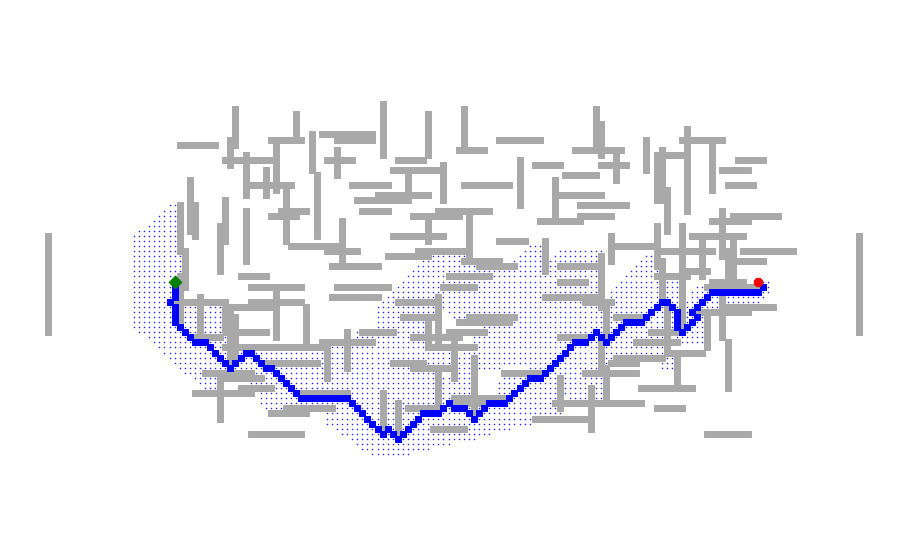

           A* search search: 130.0 path cost, 2,160 states reached


In [ ]:
plots(d3)

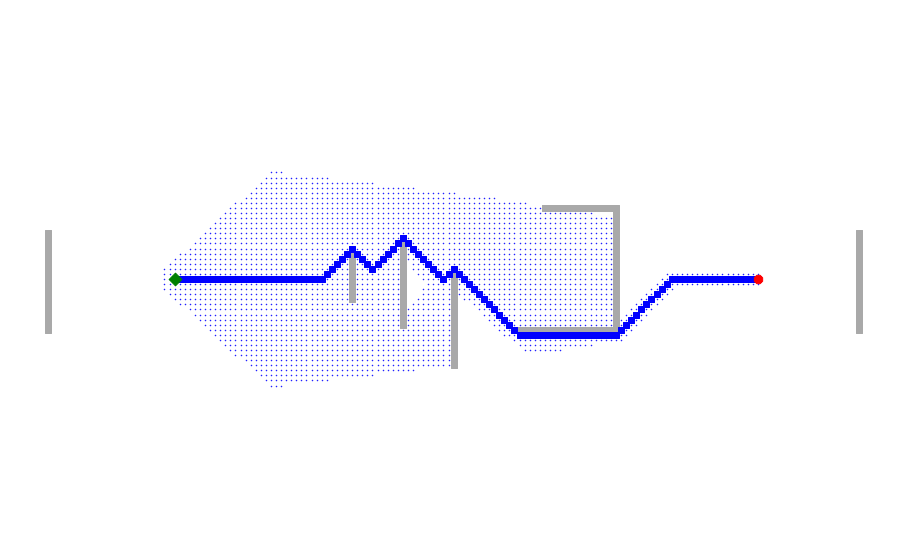

           A* search search: 115.0 path cost, 2,736 states reached


In [ ]:
plots(d7)

---
## Part C (1 points)

Write a test function that uses A* algorithm and outputs path cost and the number of state reached.

Hint:
* You could use astar_search() to get the solution.
* You could access solution.path_cost
* You could simply access the global variable reached and return its length.

In [ ]:
def test_grid_a_star(grid):
    '''
    out_1: path cost
    out_2: number of states reached 
    '''
    # YOUR CODE HERE
    solution = astar_search(grid)
    out_1 = solution.path_cost
    out_2 = len(reached)

    return out_1 , out_2

In [ ]:
out_1, out_2 = test_grid_a_star(d7)

# path cost
assert out_1 == 115.0
# number of states reached (global variable)
assert out_2 == 2736